**Telco Customer Churn**

This analysis aims to provide solutions for telcocompany related to the customers' behavior who more likely to leave the company. I intend to find out the most striking behavior of customers through EDA and later on use some of the predictive analytics techniques to determine the customers who are most likely to churn.

In [1]:
import os, warnings, scipy

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.datasets import load_diabetes
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc

warnings.filterwarnings('ignore')

In [2]:
df = pd.read_excel('C:/Users/User/Documents/Telco_customer_churn_adapted_v2.xlsx')
df.head()

,Customer ID,Tenure Months,Location,Device Class,Games Product,Music Product,Education Product,Call Center,Video Product,Use MyApp,Payment Method,Monthly Purchase (Thou. IDR),Churn Label,Longitude,Latitude,CLTV (Predicted Thou. IDR),Cluster
0,0,2,Jakarta,Mid End,Yes,Yes,No,No,No,No,Digital Wallet,70.005,Yes,106.816666,-6.2,4210.7,2
1,1,2,Jakarta,High End,No,No,No,No,No,No,Pulsa,91.910,Yes,106.816666,-6.2,3511.3,2
2,2,8,Jakarta,High End,No,No,Yes,No,Yes,Yes,Pulsa,129.545,Yes,106.816666,-6.2,6983.6,2
3,3,28,Jakarta,High End,No,No,Yes,Yes,Yes,Yes,Pulsa,136.240,Yes,106.816666,-6.2,6503.9,1
4,4,49,Jakarta,High End,No,Yes,Yes,No,Yes,Yes,Debit,134.810,Yes,106.816666,-6.2,6942.0,1


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Customer ID                   7043 non-null   int64  
 1   Tenure Months                 7043 non-null   int64  
 2   Location                      7043 non-null   object 
 3   Device Class                  7043 non-null   object 
 4   Games Product                 7043 non-null   object 
 5   Music Product                 7043 non-null   object 
 6   Education Product             7043 non-null   object 
 7   Call Center                   7043 non-null   object 
 8   Video Product                 7043 non-null   object 
 9   Use MyApp                     7043 non-null   object 
 10  Payment Method                7043 non-null   object 
 11  Monthly Purchase (Thou. IDR)  7043 non-null   float64
 12  Churn Label                   7043 non-null   object 
 13  Lon

This dataset has 3 continuous variables, they are tenure months, monthly purchase, and CLTV. It has no missing values.

**About the data**
- Churn label - Customers who left within the time period.
- Games product, Music product, Education product, Call center, Video product, and MyApp usage - Services that each customer has signed up for. 
- How long they have been a customer (Tenure months), Device class, Payment method, Monthly purchase, and Customer lifetime value - Customer account information. 
- Customer's residence (Longitude & Latitude) - Customer demographic information. 

### EDA

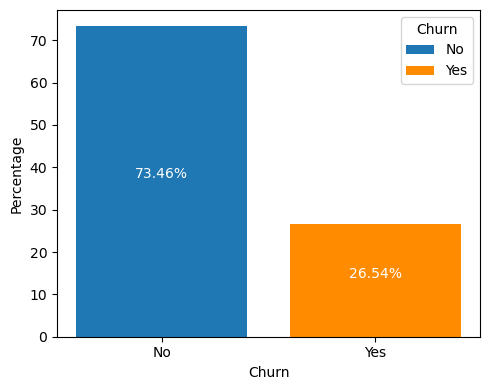

In [6]:
# count churn
churn_count = pd.DataFrame(df['Churn Label'].value_counts()).reset_index()
churn_count = churn_count.rename(columns = {'Churn Label':'Count'})

# percentage
pct = []
for i in range(len(churn_count)):
    pct.append(round((churn_count['Count'][i] / churn_count['Count'].sum()) * 100, 2))
churn_count['Pct'] = pct

# chart
fig = plt.figure(figsize = (5,4))
bars = plt.bar(churn_count['index'], churn_count['Pct'], color = ['tab:blue', 'darkorange'], label = churn_count['index'])

# label
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + (bar.get_width() / 2), yval / 2, s = f'{yval}%', va = 'bottom', ha = 'center', color = 'white')

plt.xlabel('Churn')
plt.ylabel('Percentage')
plt.legend(title = 'Churn')
plt.tight_layout()
plt.show()

Churn label tells the number of customers who left the company. Around 26% of the total customers left the company within the time period.

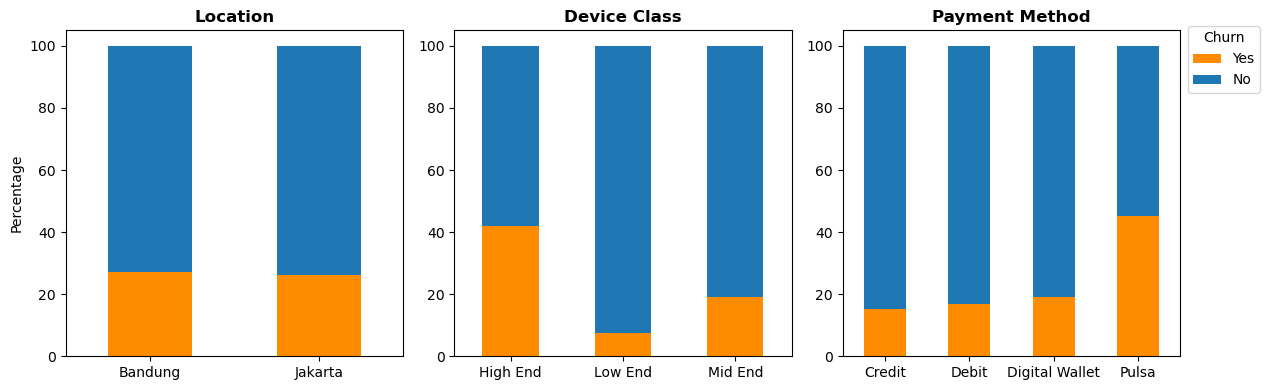

In [5]:
# count location
location_count = df.groupby(['Location'])['Churn Label'].value_counts()
location_total = df.groupby('Location')['Churn Label'].count()
location_pct = pd.DataFrame(round((location_count / location_total) * 100, 2))
location_pct = location_pct.rename(columns = {'Churn Label':'Pct'}).reset_index()
location_pct_pivot = location_pct.pivot(index='Location', columns='Churn Label', values='Pct')
location_pct_pivot = location_pct_pivot[['Yes', 'No']]

# count device class
device_count = df.groupby('Device Class')['Churn Label'].value_counts()
device_total = df.groupby('Device Class')['Churn Label'].count()
device_pct = pd.DataFrame(round((device_count / device_total) * 100, 2))
device_pct = device_pct.rename(columns = {'Churn Label':'Pct'}).reset_index()
device_pct_pivot = device_pct.pivot(index = 'Device Class', columns = 'Churn Label', values = 'Pct')
device_pct_pivot = device_pct_pivot[['Yes', 'No']]

# count payment method
payment_count = df.groupby('Payment Method')['Churn Label'].value_counts()
payment_total = df.groupby('Payment Method')['Churn Label'].count()
payment_pct = pd.DataFrame(round((payment_count / payment_total) * 100, 2))
payment_pct = payment_pct.rename(columns = {'Churn Label':'Pct'}).reset_index()
payment_pct_pivot = payment_pct.pivot(index = 'Payment Method', columns = 'Churn Label', values = 'Pct')
payment_pct_pivot = payment_pct_pivot[['Yes', 'No']]

# chart
fig = plt.figure(figsize = (12,4))
ax0 = plt.subplot2grid((1,3), (0,0))
ax1 = plt.subplot2grid((1,3), (0,1))
ax2 = plt.subplot2grid((1,3), (0,2))

location_pct_pivot.plot(kind='bar', stacked = True, ax = ax0, rot = 0, color = ['darkorange', 'tab:blue'], legend = None)
device_pct_pivot.plot(kind='bar', stacked = True, ax = ax1, rot = 0, color = ['darkorange', 'tab:blue'], legend = None)
payment_pct_pivot.plot(kind='bar', stacked = True, ax = ax2, rot = 0, color = ['darkorange', 'tab:blue'], legend = None)

ax0.set_ylabel('Percentage')
ax0.set_title('Location', weight = 'bold')
ax1.set_title('Device Class', weight = 'bold')
ax2.set_title('Payment Method', weight = 'bold')

ax0.set_xlabel(None)
ax1.set_xlabel(None)
ax2.set_xlabel(None)

# label
handles, labels = [], []
for ax in [ax0]:
    for h, l in zip(*ax.get_legend_handles_labels()):
        handles.append(h)
        labels.append(l)

fig.legend(handles, labels, title = 'Churn', loc = 'upper right',  bbox_to_anchor=(1.06, .94))
plt.tight_layout()
plt.show()

- The churn percentage is nearly identical between Bandung and Jakarta.
- The Churn percentage is higher in the case of customers with high end devices.
- The customers who use Pulsa as their payment method tend to **leave** the company more, compared to the other options which exhibit nearly equal percentage among the rest.

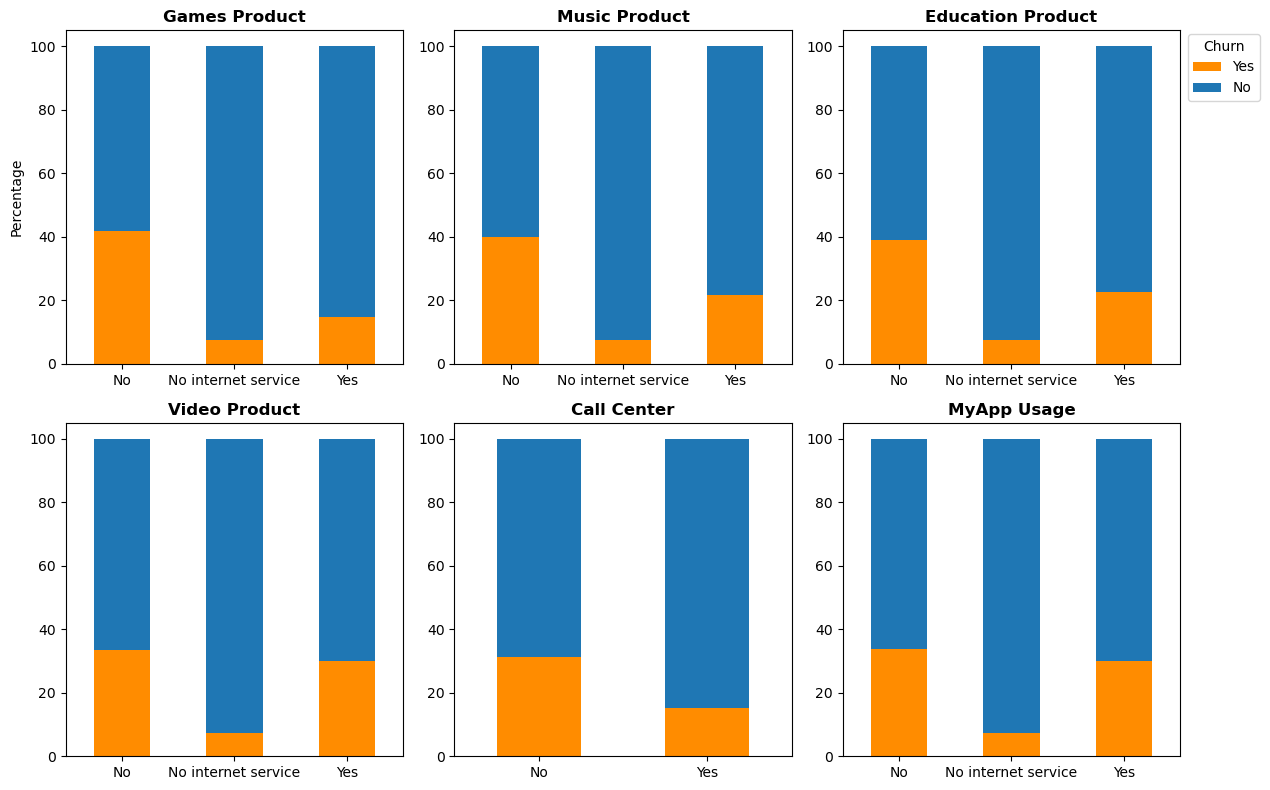

In [7]:
# count games product
games_count = df.groupby(['Games Product'])['Churn Label'].value_counts()
games_total = df.groupby('Games Product')['Churn Label'].count()
games_pct = pd.DataFrame(round((games_count / games_total) * 100, 2))
games_pct = games_pct.rename(columns = {'Churn Label':'Pct'}).reset_index()
games_pct_pivot = games_pct.pivot(index='Games Product', columns='Churn Label', values='Pct')
games_pct_pivot = games_pct_pivot[['Yes', 'No']]

# count music product
music_count = df.groupby(['Music Product'])['Churn Label'].value_counts()
music_total = df.groupby('Music Product')['Churn Label'].count()
music_pct = pd.DataFrame(round((music_count / music_total) * 100, 2))
music_pct = music_pct.rename(columns = {'Churn Label':'Pct'}).reset_index()
music_pct_pivot = music_pct.pivot(index='Music Product', columns='Churn Label', values='Pct')
music_pct_pivot = music_pct_pivot[['Yes', 'No']]

# count education product
education_count = df.groupby(['Education Product'])['Churn Label'].value_counts()
education_total = df.groupby('Education Product')['Churn Label'].count()
education_pct = pd.DataFrame(round((education_count / education_total) * 100, 2))
education_pct = education_pct.rename(columns = {'Churn Label':'Pct'}).reset_index()
education_pct_pivot = education_pct.pivot(index='Education Product', columns='Churn Label', values='Pct')
education_pct_pivot = education_pct_pivot[['Yes', 'No']]

# count video product
video_count = df.groupby(['Video Product'])['Churn Label'].value_counts()
video_total = df.groupby('Video Product')['Churn Label'].count()
video_pct = pd.DataFrame(round((video_count / video_total) * 100, 2))
video_pct = video_pct.rename(columns = {'Churn Label':'Pct'}).reset_index()
video_pct_pivot = video_pct.pivot(index='Video Product', columns='Churn Label', values='Pct')
video_pct_pivot = video_pct_pivot[['Yes', 'No']]

# count call center
call_count = df.groupby(['Call Center'])['Churn Label'].value_counts()
call_total = df.groupby('Call Center')['Churn Label'].count()
call_pct = pd.DataFrame(round((call_count / call_total) * 100, 2))
call_pct = call_pct.rename(columns = {'Churn Label':'Pct'}).reset_index()
call_pct_pivot = call_pct.pivot(index='Call Center', columns='Churn Label', values='Pct')
call_pct_pivot = call_pct_pivot[['Yes', 'No']]

# count MyApp
myapp_count = df.groupby(['Use MyApp'])['Churn Label'].value_counts()
myapp_total = df.groupby('Use MyApp')['Churn Label'].count()
myapp_pct = pd.DataFrame(round((myapp_count / myapp_total) * 100, 2))
myapp_pct = myapp_pct.rename(columns = {'Churn Label':'Pct'}).reset_index()
myapp_pct_pivot = myapp_pct.pivot(index='Use MyApp', columns='Churn Label', values='Pct')
myapp_pct_pivot = myapp_pct_pivot[['Yes', 'No']]

# chart
fig = plt.figure(figsize = (12,8))
ax0 = plt.subplot2grid((2,3), (0,0))
ax1 = plt.subplot2grid((2,3), (0,1))
ax2 = plt.subplot2grid((2,3), (0,2))
ax3 = plt.subplot2grid((2,3), (1,0))
ax4 = plt.subplot2grid((2,3), (1,1))
ax5 = plt.subplot2grid((2,3), (1,2))

games_pct_pivot.plot(kind='bar', stacked = True, ax = ax0, rot = 0, color = ['darkorange', 'tab:blue'], legend = None)
music_pct_pivot.plot(kind='bar', stacked = True, ax = ax1, rot = 0, color = ['darkorange', 'tab:blue'], legend = None)
education_pct_pivot.plot(kind='bar', stacked = True, ax = ax2, rot = 0, color = ['darkorange', 'tab:blue'], legend = None)
video_pct_pivot.plot(kind='bar', stacked = True, ax = ax3, rot = 0, color = ['darkorange', 'tab:blue'], legend = None)
call_pct_pivot.plot(kind='bar', stacked = True, ax = ax4, rot = 0, color = ['darkorange', 'tab:blue'], legend = None)
myapp_pct_pivot.plot(kind='bar', stacked = True, ax = ax5, rot = 0, color = ['darkorange', 'tab:blue'], legend = None)

ax0.set_ylabel('Percentage')
ax0.set_title('Games Product', weight = 'bold')
ax1.set_title('Music Product', weight = 'bold')
ax2.set_title('Education Product', weight = 'bold')
ax3.set_title('Video Product', weight = 'bold')
ax4.set_title('Call Center', weight = 'bold')
ax5.set_title('MyApp Usage', weight = 'bold')

ax0.set_xlabel(None)
ax1.set_xlabel(None)
ax2.set_xlabel(None)
ax3.set_xlabel(None)
ax4.set_xlabel(None)
ax5.set_xlabel(None)

# label
handles, labels = [], []
for ax in [ax0]:
    for h, l in zip(*ax.get_legend_handles_labels()):
        handles.append(h)
        labels.append(l)

fig.legend(handles, labels, title = 'Churn', loc = 'upper right',  bbox_to_anchor=(1.06, .96))
plt.tight_layout()
plt.show()

The churn percentages among all product services are nearly identical, with customers who don't use the services exhibit **higher churn rates** than those who do. Specifically, for the video product and MyApp usage, the churn percentage is almost equal between users and non-users, although the non-users comprise a larger portion of churned customers.

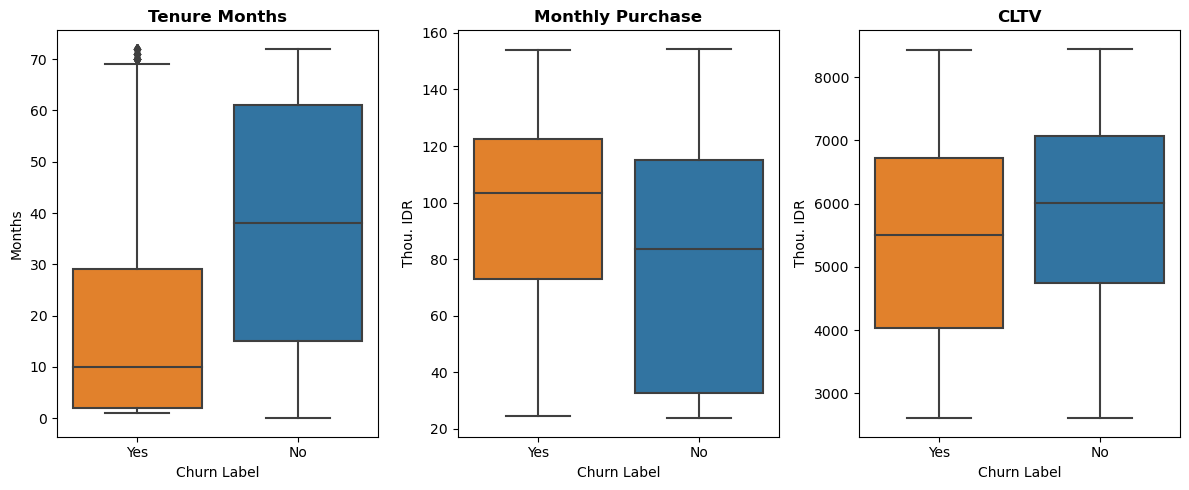

In [8]:
# numerical variables
fig = plt.figure(figsize = (12,5))
ax0 = plt.subplot2grid((1,3), (0,0))
ax1 = plt.subplot2grid((1,3), (0,1))
ax2 = plt.subplot2grid((1,3), (0,2))

sns.boxplot(x = 'Churn Label', y = 'Tenure Months', data = df, ax = ax0, palette = ["#ff7f0e", "#1f77b4"])
sns.boxplot(x = 'Churn Label', y = 'Monthly Purchase (Thou. IDR)', data = df, ax = ax1, palette = ["#ff7f0e", "#1f77b4"])
sns.boxplot(x = 'Churn Label', y = 'CLTV (Predicted Thou. IDR)', data = df, ax = ax2, palette = ["#ff7f0e", "#1f77b4"])

ax0.set_title('Tenure Months', weight = 'bold')
ax0.set_ylabel('Months')

ax1.set_title('Monthly Purchase', weight = 'bold')
ax1.set_ylabel('Thou. IDR')

ax2.set_title('CLTV', weight = 'bold')
ax2.set_ylabel('Thou. IDR')

plt.tight_layout()
plt.show()

- The median tenure for customers who have left the company is around 10 months.
- The customers who have churned have a higher monthly purchase than those who haven't. The median is above 100.
- The median CLTV of customers who have churned is lower than who haven't.

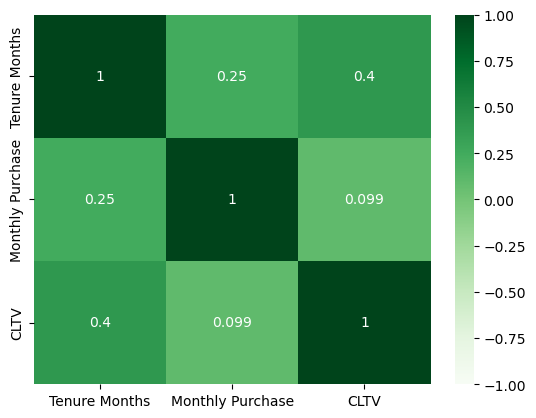

In [9]:
# correlation
df_corr = df[['Tenure Months', 'Monthly Purchase (Thou. IDR)', 'CLTV (Predicted Thou. IDR)']]
df_corr = df_corr.rename(columns = {'Monthly Purchase (Thou. IDR)':'Monthly Purchase',
                                    'CLTV (Predicted Thou. IDR)':'CLTV'})
sns.heatmap(df_corr.corr(), vmin = -1, vmax = 1, annot = True, cmap = 'Greens')
plt.show()

CLTV has a higher correlation with tenure months than with monthly purchase.

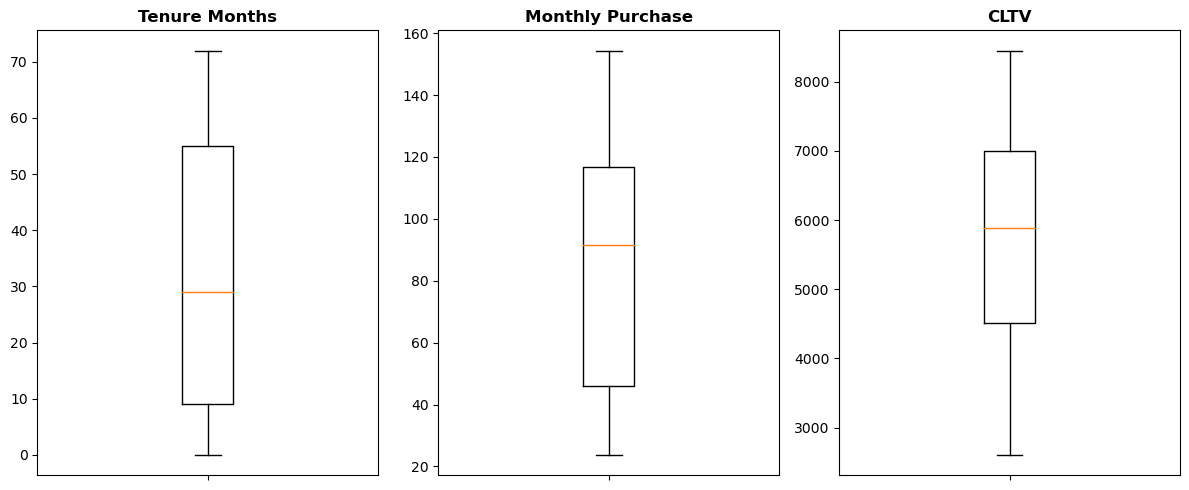

In [512]:
# check for outliers
fig = plt.figure(figsize = (12,5))
ax0 = plt.subplot2grid((1,3), (0,0))
ax1 = plt.subplot2grid((1,3), (0,1))
ax2 = plt.subplot2grid((1,3), (0,2))

ax0.boxplot(df['Tenure Months'])
ax1.boxplot(df['Monthly Purchase (Thou. IDR)'])
ax2.boxplot(df['CLTV (Predicted Thou. IDR)'])

ax0.set_xticklabels([None])
ax1.set_xticklabels([None])
ax2.set_xticklabels([None])

ax0.set_title('Tenure Months', weight = 'bold')
ax1.set_title('Monthly Purchase', weight = 'bold')
ax2.set_title('CLTV', weight = 'bold')

plt.tight_layout()
plt.show()

Checking for the outliers, it seems none of the values are beyond the whiskers.

### Data Preparation

In [4]:
# cleaning categorical variables
df = df.replace('No internet service', 'No')

# standardizing continuous variables
df['Tenure'] = stats.zscore(df['Tenure Months'])
df['Monthly Purchase'] = stats.zscore(df['Monthly Purchase (Thou. IDR)'])
df['CLTV'] = stats.zscore(df['CLTV (Predicted Thou. IDR)'])

# creating derived features
tenure_group = []
for i in df['Tenure Months']:
    if i <= 12:
        tenure_group.append('0-1 year')
    elif i <= 24:
        tenure_group.append('1-2 years')
    elif i <= 36:
        tenure_group.append('2-3 years')
    elif i <= 48:
        tenure_group.append('3-4 years')
    elif i <= 60:
        tenure_group.append('4-5 years')
    elif i <= 72:
        tenure_group.append('5-6 years')        
df['Tenure Group'] = tenure_group

df.drop(columns = ['Tenure Months', 'Cluster', 'Customer ID', 'Longitude', 'Latitude',
                   'Monthly Purchase (Thou. IDR)', 'CLTV (Predicted Thou. IDR)'], inplace = True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Location           7043 non-null   object 
 1   Device Class       7043 non-null   object 
 2   Games Product      7043 non-null   object 
 3   Music Product      7043 non-null   object 
 4   Education Product  7043 non-null   object 
 5   Call Center        7043 non-null   object 
 6   Video Product      7043 non-null   object 
 7   Use MyApp          7043 non-null   object 
 8   Payment Method     7043 non-null   object 
 9   Churn Label        7043 non-null   object 
 10  Tenure             7043 non-null   float64
 11  Monthly Purchase   7043 non-null   float64
 12  CLTV               7043 non-null   float64
 13  Tenure Group       7043 non-null   object 
dtypes: float64(3), object(11)
memory usage: 770.5+ KB


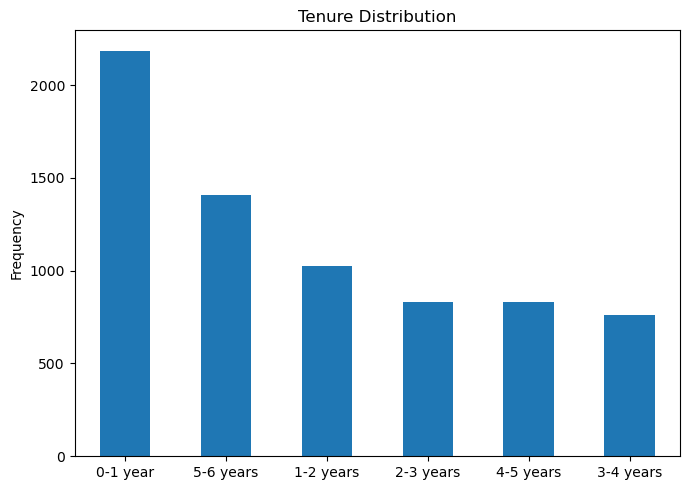

In [5]:
# tenure group chart
fig = plt.figure(figsize = (7,5))
df['Tenure Group'].value_counts().plot(kind = 'bar', rot = 0)

plt.ylabel('Frequency')
plt.title('Tenure Distribution')
plt.tight_layout()
plt.show()

After checking the data distribution in each tenure bin, we found that most of the customers have a tenure of 0-1 year, followed by 5-6 years and 1-2 years.

In [6]:
# creating dummy variables
df_copy = df.copy()
dummies_tenure = pd.get_dummies(df_copy['Tenure Group'])
dummies_device = pd.get_dummies(df_copy['Device Class'])
dummies_location = pd.get_dummies(df_copy['Location'])
dummies_payment = pd.get_dummies(df_copy['Payment Method'])

for i in ['Video Product', 'Music Product', 'Education Product', 'Use MyApp', 'Games Product', 'Call Center', 'Churn Label']:
    df_copy[i] = df_copy[i].map({'Yes':1, 'No':0})
    
# final dataset
df_final = pd.concat([df_copy, dummies_tenure, dummies_device, dummies_location, dummies_payment], axis = 1)
df_final.drop(columns = ['Location', 'Device Class', 'Payment Method', 'Tenure Group'], inplace = True)
df_final = df_final[['Tenure', 'Monthly Purchase', 'CLTV', 'Games Product', 'Music Product', 'Education Product',
                     'Call Center', 'Video Product', 'Use MyApp', '0-1 year', '1-2 years', '2-3 years', '3-4 years', '4-5 years', '5-6 years',
                     'High End', 'Low End', 'Mid End', 'Bandung', 'Jakarta', 'Credit', 'Debit', 'Digital Wallet', 'Pulsa', 'Churn Label']]
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 25 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Tenure             7043 non-null   float64
 1   Monthly Purchase   7043 non-null   float64
 2   CLTV               7043 non-null   float64
 3   Games Product      7043 non-null   int64  
 4   Music Product      7043 non-null   int64  
 5   Education Product  7043 non-null   int64  
 6   Call Center        7043 non-null   int64  
 7   Video Product      7043 non-null   int64  
 8   Use MyApp          7043 non-null   int64  
 9   0-1 year           7043 non-null   uint8  
 10  1-2 years          7043 non-null   uint8  
 11  2-3 years          7043 non-null   uint8  
 12  3-4 years          7043 non-null   uint8  
 13  4-5 years          7043 non-null   uint8  
 14  5-6 years          7043 non-null   uint8  
 15  High End           7043 non-null   uint8  
 16  Low End            7043 

## Data Modelling

We use different models to the dataset in order to find the proper model that can fit the data accurately.

### Logistic Regression

In [24]:
# split dataset
X = df_final.drop(columns = ['Churn Label'])
y = df_final['Churn Label']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, random_state = 42)

# scaling dataset
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

# model
model_1 = LogisticRegression(penalty = 'none').fit(X_train_scaled, y_train)
y_pred_1 = model_1.predict(X_val_scaled)

# accuracy
accuracy_1 = accuracy_score(y_val, y_pred_1)
print('Accuracy: {:.2f}%'.format(accuracy_1 * 100))
print('\nConfussion Matrix:\n', confusion_matrix(y_val, y_pred_1))
print('\nClassification Report:\n', classification_report(y_val, y_pred_1))

Accuracy: 79.28%

Confussion Matrix:
 [[917  92]
 [200 200]]

Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.91      0.86      1009
           1       0.68      0.50      0.58       400

    accuracy                           0.79      1409
   macro avg       0.75      0.70      0.72      1409
weighted avg       0.78      0.79      0.78      1409



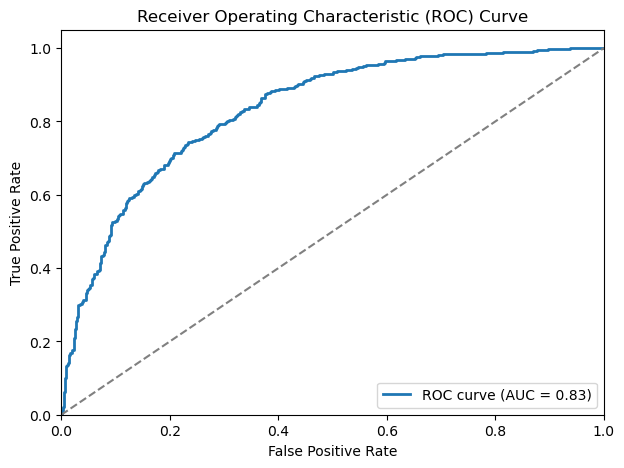

In [17]:
# ROC curve and AUC
y_prob = model_1.predict_proba(X_val_scaled)[:,1]
fpr, tpr, thresholds = roc_curve(y_val, y_prob)
roc_auc = auc(fpr, tpr)

# plot ROC curve
plt.figure(figsize = (7,5))
plt.plot(fpr, tpr, color = 'tab:blue', lw = 2, label = 'ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0,1], [0,1], color = 'gray', linestyle = '--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc = 'lower right')
plt.show()

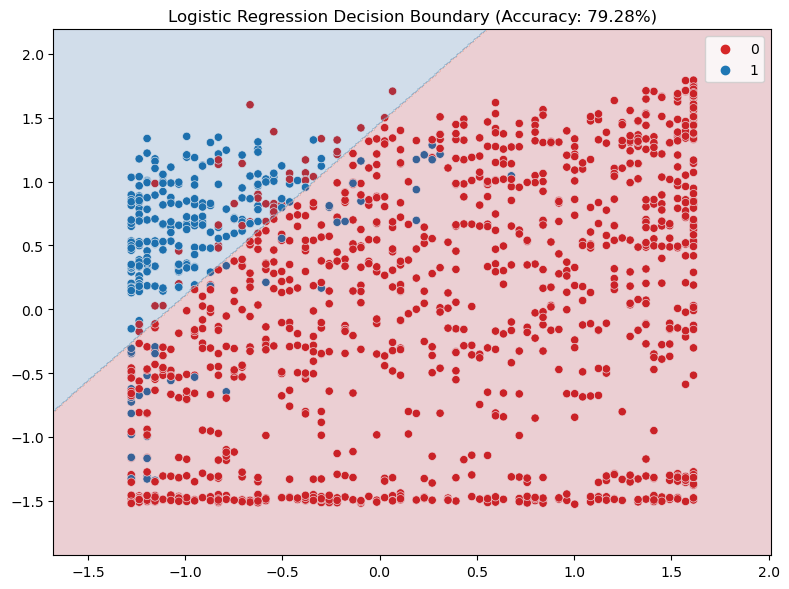

In [37]:
# model for contour
model_1 = LogisticRegression().fit(X_val.iloc[:,:2], y_val)

# min and max values
x_min, x_max = X_val.iloc[:, 0].min() - .4, X_val.iloc[:, 0].max() + .4
y_min, y_max = X_val.iloc[:, 1].min() - .4, X_val.iloc[:, 1].max() + .4

# contour
xx_1, yy_1 = np.meshgrid(np.arange(x_min, x_max, .01), np.arange(y_min, y_max, .01))
Z_1 = model_1.predict(np.c_[xx_1.ravel(), yy_1.ravel()])
Z_1 = Z_1.reshape(xx_1.shape)

# plot
plt.figure(figsize = (8,6))
sns.scatterplot(x = X_val.iloc[:,0], # tenure months
                y = X_val.iloc[:,1], # monthly purchase
                hue = y_pred_1,
                palette = {1: 'tab:blue', 0: 'tab:red'},
                marker = 'o')
plt.contourf(xx_1, yy_1, Z_1, alpha = .2, cmap = 'RdBu')
plt.title('Logistic Regression Decision Boundary (Accuracy: {:.2f}%)'.format(accuracy_1 * 100))
plt.xlabel(None)
plt.ylabel(None)
plt.tight_layout()
plt.show()

### Decision Tree

In [19]:
# split dataset
X = df_final.drop(columns = ['Churn Label'])
y = df_final['Churn Label']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, random_state = 42)

# scaling dataset
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

# model
model_2 = DecisionTreeClassifier().fit(X_train_scaled, y_train)
y_pred_2 = model_2.predict(X_val_scaled)

# accuracy
accuracy_2 = accuracy_score(y_val, y_pred_2)
print('Accuracy: {:.2f}%'.format(accuracy_2 * 100))
print('\nConfussion Matrix:\n', confusion_matrix(y_val, y_pred_2))
print('\nClassification Report:\n', classification_report(y_val, y_pred_2))

Accuracy: 71.04%

Confussion Matrix:
 [[809 200]
 [208 192]]

Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.80      0.80      1009
           1       0.49      0.48      0.48       400

    accuracy                           0.71      1409
   macro avg       0.64      0.64      0.64      1409
weighted avg       0.71      0.71      0.71      1409



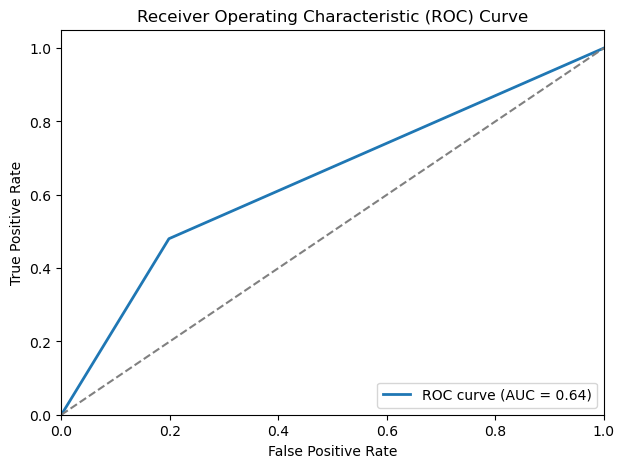

In [20]:
# ROC curve and AUC
y_prob = model_2.predict_proba(X_val_scaled)[:,1]
fpr, tpr, thresholds = roc_curve(y_val, y_prob)
roc_auc = auc(fpr, tpr)

# plot ROC curve
plt.figure(figsize = (7,5))
plt.plot(fpr, tpr, color = 'tab:blue', lw = 2, label = 'ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0,1], [0,1], color = 'gray', linestyle = '--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc = 'lower right')
plt.show()

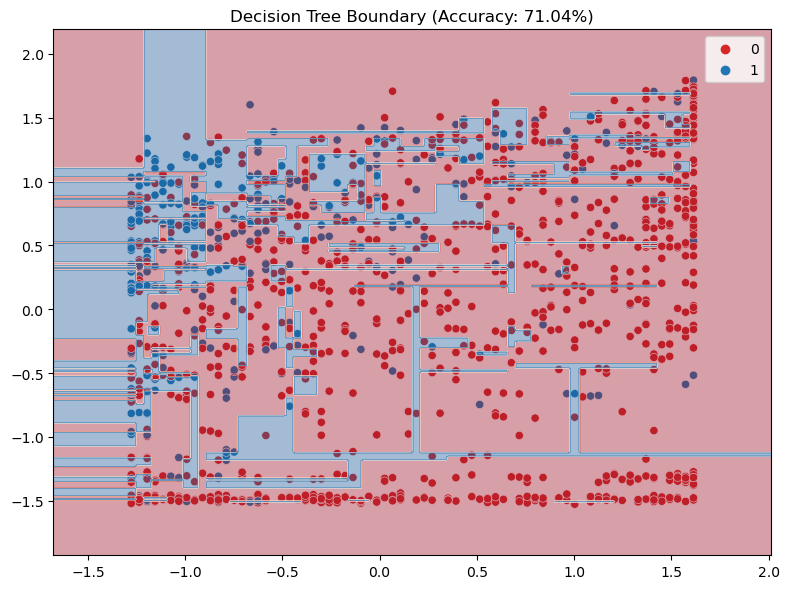

In [22]:
# model for contour
model_2 = DecisionTreeClassifier().fit(X_val.iloc[:,:2], y_val)

# min and max values
x_min, x_max = X_val.iloc[:, 0].min() - .4, X_val.iloc[:, 0].max() + .4
y_min, y_max = X_val.iloc[:, 1].min() - .4, X_val.iloc[:, 1].max() + .4

# contour
xx_2, yy_2 = np.meshgrid(np.arange(x_min, x_max, .01), np.arange(y_min, y_max, .01))
Z_2 = model_2.predict(np.c_[xx_2.ravel(), yy_2.ravel()])
Z_2 = Z_2.reshape(xx_2.shape)

# plot
plt.figure(figsize = (8,6))
sns.scatterplot(x = X_val.iloc[:,0], # tenure months
                y = X_val.iloc[:,1], # monthly purchase
                hue = y_pred_2,
                palette = {1: 'tab:blue', 0: 'tab:red'},
                marker = 'o')
plt.contourf(xx_2, yy_2, Z_2, alpha = .4, cmap = 'RdBu')
plt.title('Decision Tree Boundary (Accuracy: {:.2f}%)'.format(accuracy_2 * 100))
# plt.legend(['Yes', 'No'], loc = 'upper right', title = 'Churn', bbox_to_anchor = (1.15, 1))
plt.xlabel(None)
plt.ylabel(None)
plt.tight_layout()
plt.show()

### Random Forest

In [23]:
# split dataset
X = df_final.drop(columns = ['Churn Label'])
y = df_final['Churn Label']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, random_state = 42)

# scaling dataset
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

# model
model_3 = RandomForestClassifier().fit(X_train_scaled, y_train)
y_pred_3 = model_3.predict(X_val_scaled)

# accuracy
accuracy_3 = accuracy_score(y_val, y_pred_3)
print('Accuracy: {:.2f}%'.format(accuracy_3 * 100))
print('\nConfussion Matrix:\n', confusion_matrix(y_val, y_pred_3))
print('\nClassification Report:\n', classification_report(y_val, y_pred_3))

Accuracy: 77.79%

Confussion Matrix:
 [[908 101]
 [212 188]]

Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.90      0.85      1009
           1       0.65      0.47      0.55       400

    accuracy                           0.78      1409
   macro avg       0.73      0.68      0.70      1409
weighted avg       0.77      0.78      0.77      1409



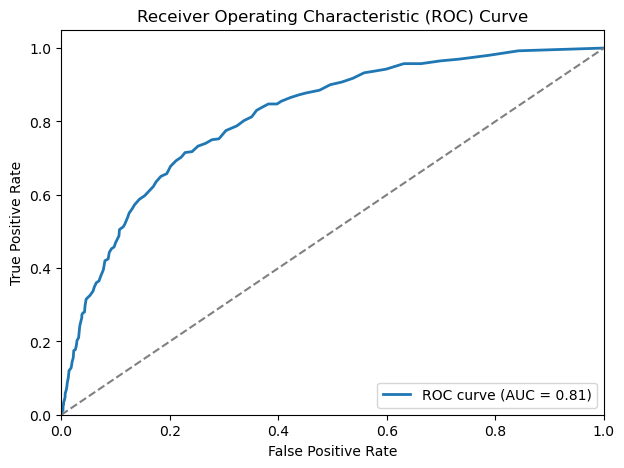

In [24]:
# ROC curve and AUC
y_prob = model_3.predict_proba(X_val_scaled)[:,1]
fpr, tpr, thresholds = roc_curve(y_val, y_prob)
roc_auc = auc(fpr, tpr)

# plot ROC curve
plt.figure(figsize = (7,5))
plt.plot(fpr, tpr, color = 'tab:blue', lw = 2, label = 'ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0,1], [0,1], color = 'gray', linestyle = '--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc = 'lower right')
plt.show()

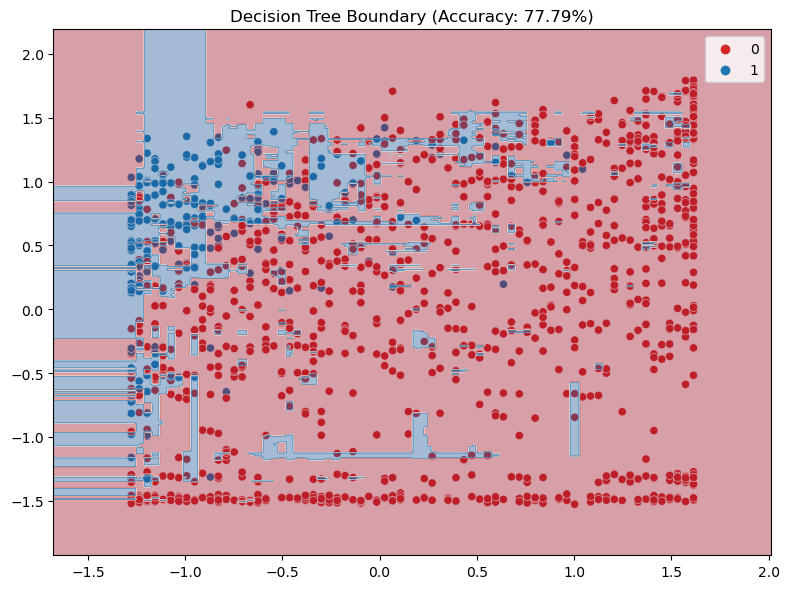

In [25]:
# model for contour
model_3 = RandomForestClassifier().fit(X_val.iloc[:,:2], y_val)

# min and max values
x_min, x_max = X_val.iloc[:, 0].min() - .4, X_val.iloc[:, 0].max() + .4
y_min, y_max = X_val.iloc[:, 1].min() - .4, X_val.iloc[:, 1].max() + .4

# contour
xx_3, yy_3 = np.meshgrid(np.arange(x_min, x_max, .01), np.arange(y_min, y_max, .01))
Z_3 = model_3.predict(np.c_[xx_3.ravel(), yy_3.ravel()])
Z_3 = Z_3.reshape(xx_3.shape)

# plot
plt.figure(figsize = (8,6))
sns.scatterplot(x = X_val.iloc[:,0], # tenure months
                y = X_val.iloc[:,1], # monthly purchase
                hue = y_pred_3,
                palette = {0: 'tab:red', 1: 'tab:blue'}, label = None,
                marker = 'o')
plt.contourf(xx_3, yy_3, Z_3, alpha = .4, cmap = 'RdBu')
plt.title('Decision Tree Boundary (Accuracy: {:.2f}%)'.format(accuracy_3 * 100))
plt.xlabel(None)
plt.ylabel(None)
plt.tight_layout()
plt.show()

### Support Vector Machine

In [26]:
# split dataset
X = df_final.drop(columns = ['Churn Label'])
y = df_final['Churn Label']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, random_state = 42)

# scaling dataset
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

# model
model_4 = SVC(gamma = 'auto', probability = True).fit(X_train_scaled, y_train)
y_pred_4 = model_4.predict(X_val_scaled)

# accuracy
accuracy_4 = accuracy_score(y_val, y_pred_4)
print('Accuracy: {:.2f}%'.format(accuracy_4 * 100))
print('\nConfussion Matrix:\n', confusion_matrix(y_val, y_pred_4))
print('\nClassification Report:\n', classification_report(y_val, y_pred_4))

Accuracy: 78.99%

Confussion Matrix:
 [[920  89]
 [207 193]]

Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.91      0.86      1009
           1       0.68      0.48      0.57       400

    accuracy                           0.79      1409
   macro avg       0.75      0.70      0.71      1409
weighted avg       0.78      0.79      0.78      1409



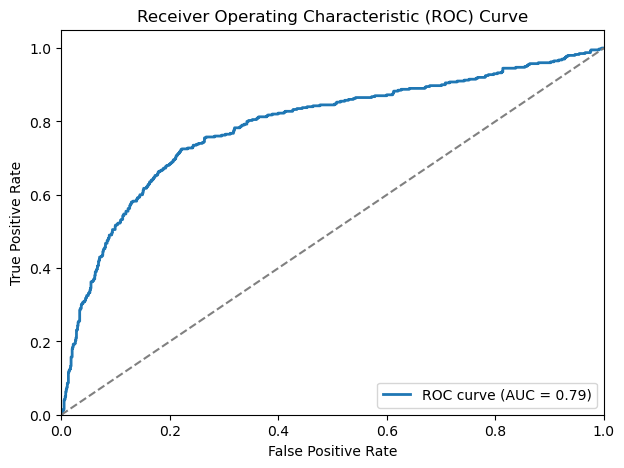

In [27]:
# ROC curve and AUC
y_prob = model_4.predict_proba(X_val_scaled)[:,1]
fpr, tpr, thresholds = roc_curve(y_val, y_prob)
roc_auc = auc(fpr, tpr)

# plot ROC curve
plt.figure(figsize = (7,5))
plt.plot(fpr, tpr, color = 'tab:blue', lw = 2, label = 'ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0,1], [0,1], color = 'gray', linestyle = '--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc = 'lower right')
plt.show()

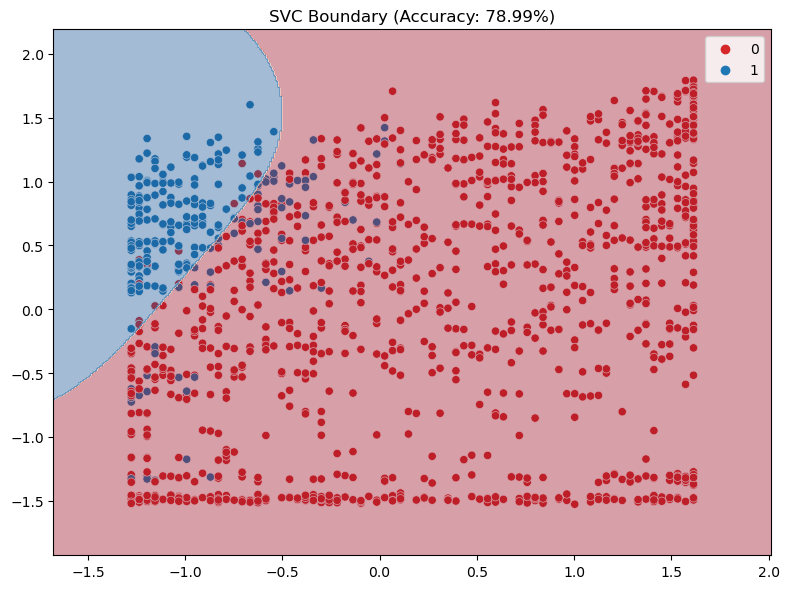

In [28]:
# model for contour
model_4 = SVC(gamma = 'auto', probability = True).fit(X_val.iloc[:,:2], y_val)

# min and max values
x_min, x_max = X_val.iloc[:, 0].min() - .4, X_val.iloc[:, 0].max() + .4
y_min, y_max = X_val.iloc[:, 1].min() - .4, X_val.iloc[:, 1].max() + .4

# contour
xx_4, yy_4 = np.meshgrid(np.arange(x_min, x_max, .01), np.arange(y_min, y_max, .01))
Z_4 = model_4.predict(np.c_[xx_4.ravel(), yy_4.ravel()])
Z_4 = Z_4.reshape(xx_4.shape)

# plot
plt.figure(figsize = (8,6))
sns.scatterplot(x = X_val.iloc[:,0], # tenure months
                y = X_val.iloc[:,1], # monthly purchase
                hue = y_pred_4,
                palette = {0: 'tab:red', 1: 'tab:blue'}, label = None,
                marker = 'o')
plt.contourf(xx_4, yy_4, Z_4, alpha = .4, cmap = 'RdBu')
plt.title('SVC Boundary (Accuracy: {:.2f}%)'.format(accuracy_4 * 100))
plt.xlabel(None)
plt.ylabel(None)
plt.tight_layout()
plt.show()

### Gaussian Naive Bayes

In [29]:
# split dataset
X = df_final.drop(columns = ['Churn Label'])
y = df_final['Churn Label']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, random_state = 42)

# scaling dataset
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

# model
model_5 = GaussianNB().fit(X_train_scaled, y_train)
y_pred_5 = model_5.predict(X_val_scaled)

# accuracy
accuracy_5 = accuracy_score(y_val, y_pred_5)
print('Accuracy: {:.2f}%'.format(accuracy_5 * 100))
print('\nConfussion Matrix:\n', confusion_matrix(y_val, y_pred_5))
print('\nClassification Report:\n', classification_report(y_val, y_pred_5))

Accuracy: 74.80%

Confussion Matrix:
 [[767 242]
 [113 287]]

Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.76      0.81      1009
           1       0.54      0.72      0.62       400

    accuracy                           0.75      1409
   macro avg       0.71      0.74      0.71      1409
weighted avg       0.78      0.75      0.76      1409



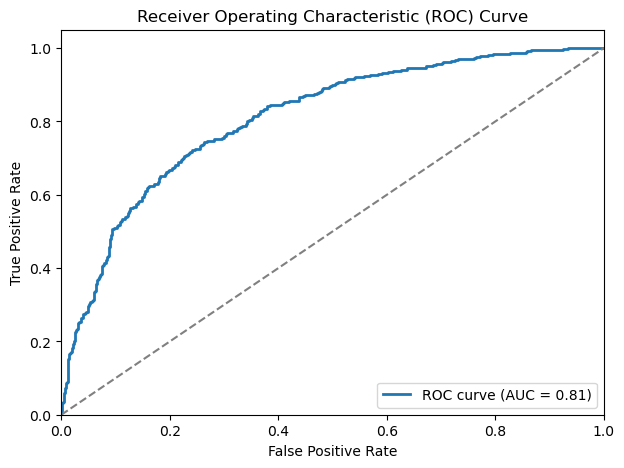

In [30]:
# ROC curve and AUC
y_prob = model_5.predict_proba(X_val_scaled)[:,1]
fpr, tpr, thresholds = roc_curve(y_val, y_prob)
roc_auc = auc(fpr, tpr)

# plot ROC curve
plt.figure(figsize = (7,5))
plt.plot(fpr, tpr, color = 'tab:blue', lw = 2, label = 'ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0,1], [0,1], color = 'gray', linestyle = '--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc = 'lower right')
plt.show()

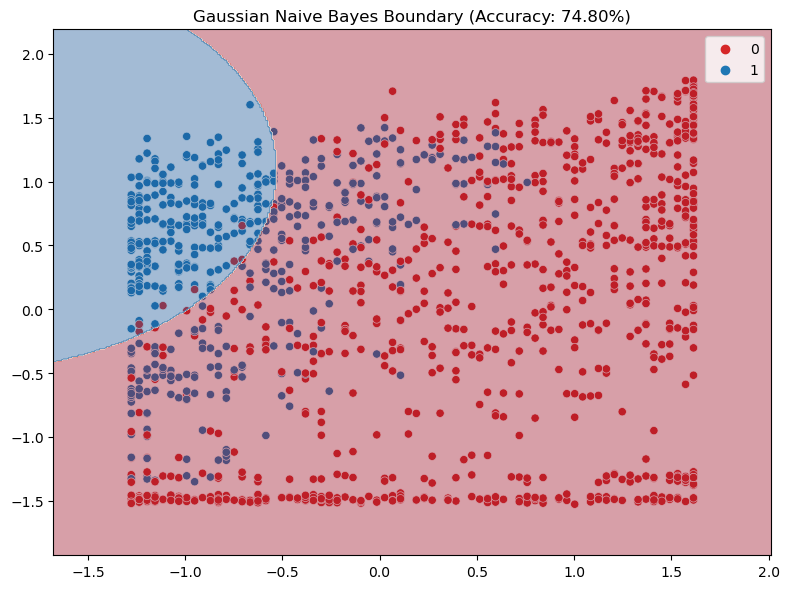

In [31]:
# model for contour
model_5 = GaussianNB().fit(X_val.iloc[:,:2], y_val)

# min and max values
x_min, x_max = X_val.iloc[:, 0].min() - .4, X_val.iloc[:, 0].max() + .4
y_min, y_max = X_val.iloc[:, 1].min() - .4, X_val.iloc[:, 1].max() + .4

# contour
xx_5, yy_5 = np.meshgrid(np.arange(x_min, x_max, .01), np.arange(y_min, y_max, .01))
Z_5 = model_5.predict(np.c_[xx_5.ravel(), yy_5.ravel()])
Z_5 = Z_5.reshape(xx_5.shape)

# plot
plt.figure(figsize = (8,6))
sns.scatterplot(x = X_val.iloc[:,0], # tenure months
                y = X_val.iloc[:,1], # monthly purchase
                hue = y_pred_5,
                palette = {0: 'tab:red', 1: 'tab:blue'}, label = None,
                marker = 'o')
plt.contourf(xx_5, yy_5, Z_5, alpha = .4, cmap = 'RdBu')
plt.title('Gaussian Naive Bayes Boundary (Accuracy: {:.2f}%)'.format(accuracy_5 * 100))
plt.xlabel(None)
plt.ylabel(None)
plt.tight_layout()
plt.show()

### KNN

In [32]:
# split dataset
X = df_final.drop(columns = ['Churn Label'])
y = df_final['Churn Label']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, random_state = 42)

# scaling dataset
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

# model
model_6 = KNeighborsClassifier().fit(X_train_scaled, y_train)
y_pred_6 = model_6.predict(X_val_scaled)

# accuracy
accuracy_6 = accuracy_score(y_val, y_pred_6)
print('Accuracy: {:.2f}%'.format(accuracy_6 * 100))
print('\nConfussion Matrix:\n', confusion_matrix(y_val, y_pred_6))
print('\nClassification Report:\n', classification_report(y_val, y_pred_6))

Accuracy: 76.22%

Confussion Matrix:
 [[875 134]
 [201 199]]

Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.87      0.84      1009
           1       0.60      0.50      0.54       400

    accuracy                           0.76      1409
   macro avg       0.71      0.68      0.69      1409
weighted avg       0.75      0.76      0.76      1409



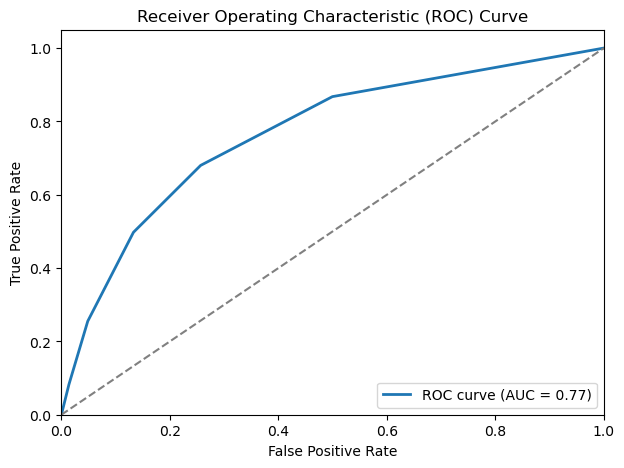

In [33]:
# ROC curve and AUC
y_prob = model_6.predict_proba(X_val_scaled)[:,1]
fpr, tpr, thresholds = roc_curve(y_val, y_prob)
roc_auc = auc(fpr, tpr)

# plot ROC curve
plt.figure(figsize = (7,5))
plt.plot(fpr, tpr, color = 'tab:blue', lw = 2, label = 'ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0,1], [0,1], color = 'gray', linestyle = '--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc = 'lower right')
plt.show()

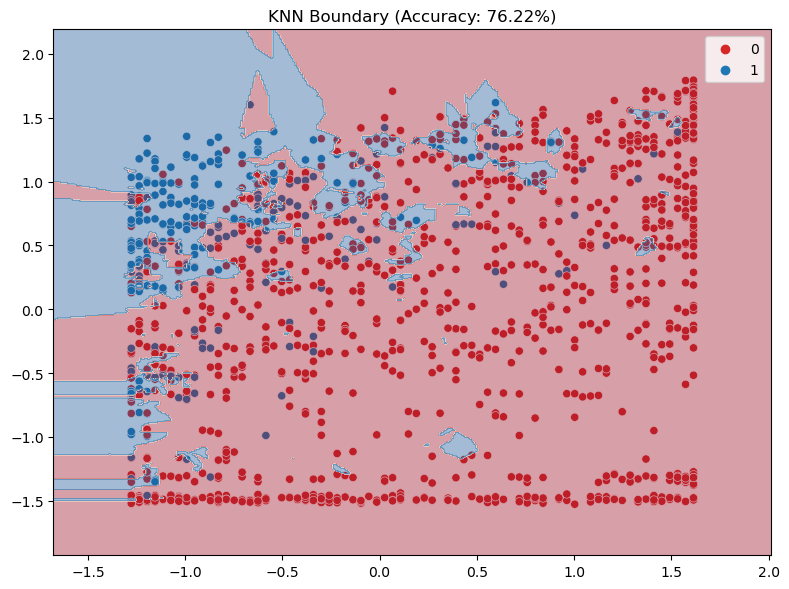

In [34]:
# model for contour
model_6 = KNeighborsClassifier().fit(X_val.iloc[:,:2], y_val)

# min and max values
x_min, x_max = X_val.iloc[:, 0].min() - .4, X_val.iloc[:, 0].max() + .4
y_min, y_max = X_val.iloc[:, 1].min() - .4, X_val.iloc[:, 1].max() + .4

# contour
xx_6, yy_6 = np.meshgrid(np.arange(x_min, x_max, .01), np.arange(y_min, y_max, .01))
Z_6 = model_6.predict(np.c_[xx_6.ravel(), yy_6.ravel()])
Z_6 = Z_6.reshape(xx_6.shape)

# plot
plt.figure(figsize = (8,6))
sns.scatterplot(x = X_val.iloc[:,0], # tenure months
                y = X_val.iloc[:,1], # monthly purchase
                hue = y_pred_6,
                palette = {0: 'tab:red', 1: 'tab:blue'}, label = None,
                marker = 'o')
plt.contourf(xx_6, yy_6, Z_6, alpha = .4, cmap = 'RdBu')
plt.title('KNN Boundary (Accuracy: {:.2f}%)'.format(accuracy_6 * 100))
plt.xlabel(None)
plt.ylabel(None)
plt.tight_layout()
plt.show()

## Summary

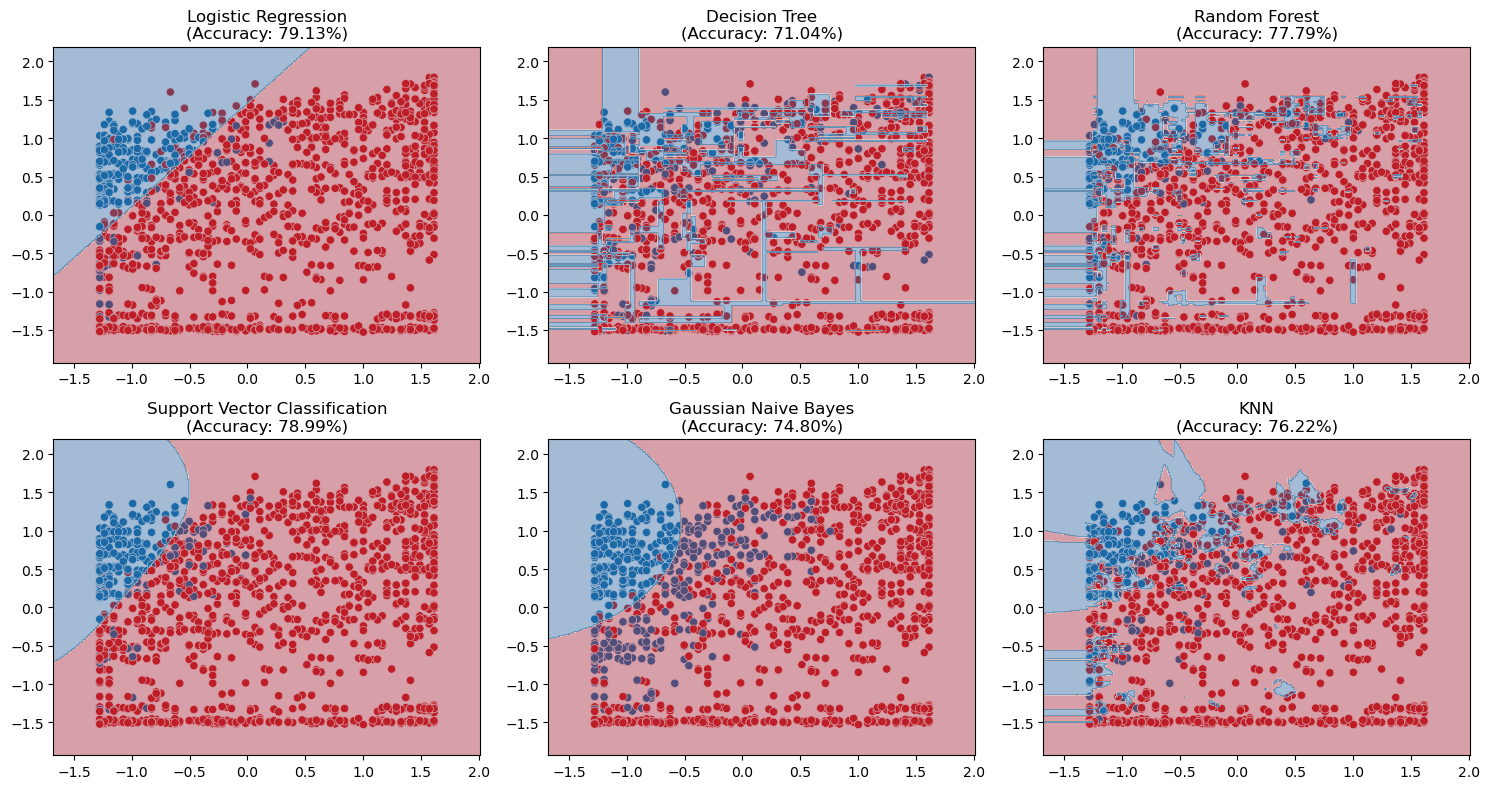

In [35]:
fig = plt.figure(figsize = (15,8))
ax0 = plt.subplot2grid((2,3), (0,0))
ax1 = plt.subplot2grid((2,3), (0,1))
ax2 = plt.subplot2grid((2,3), (0,2))
ax3 = plt.subplot2grid((2,3), (1,0))
ax4 = plt.subplot2grid((2,3), (1,1))
ax5 = plt.subplot2grid((2,3), (1,2))

# logistic regression
sns.scatterplot(x = X_val.iloc[:,0], # tenure months
                y = X_val.iloc[:,1], # monthly purchase
                hue = y_pred_1,
                palette = {1: 'tab:blue', 0: 'tab:red'},
                marker = 'o',
                ax = ax0,
                legend = None)
ax0.contourf(xx_1, yy_1, Z_1, alpha = .4, cmap = 'RdBu')
ax0.set_title('Logistic Regression\n(Accuracy: {:.2f}%)'.format(accuracy_1 * 100))
ax0.set_xlabel(None)
ax0.set_ylabel(None)

# Decision Tree
sns.scatterplot(x = X_val.iloc[:,0], # tenure months
                y = X_val.iloc[:,1], # monthly purchase
                hue = y_pred_2,
                palette = {1: 'tab:blue', 0: 'tab:red'},
                marker = 'o',
                ax = ax1,
                legend = None)
ax1.contourf(xx_2, yy_2, Z_2, alpha = .4, cmap = 'RdBu')
ax1.set_title('Decision Tree\n(Accuracy: {:.2f}%)'.format(accuracy_2 * 100))
ax1.set_xlabel(None)
ax1.set_ylabel(None)

# Random Forest
sns.scatterplot(x = X_val.iloc[:,0], # tenure months
                y = X_val.iloc[:,1], # monthly purchase
                hue = y_pred_3,
                palette = {0: 'tab:red', 1: 'tab:blue'}, label = None,
                marker = 'o',
                ax = ax2,
                legend = None)
ax2.contourf(xx_3, yy_3, Z_3, alpha = .4, cmap = 'RdBu')
ax2.set_title('Random Forest\n(Accuracy: {:.2f}%)'.format(accuracy_3 * 100))
ax2.set_xlabel(None)
ax2.set_ylabel(None)

# SVM
sns.scatterplot(x = X_val.iloc[:,0], # tenure months
                y = X_val.iloc[:,1], # monthly purchase
                hue = y_pred_4,
                palette = {0: 'tab:red', 1: 'tab:blue'}, label = None,
                marker = 'o',
                ax = ax3,
                legend = None)
ax3.contourf(xx_4, yy_4, Z_4, alpha = .4, cmap = 'RdBu')
ax3.set_title('Support Vector Classification\n(Accuracy: {:.2f}%)'.format(accuracy_4 * 100))
ax3.set_xlabel(None)
ax3.set_ylabel(None)

# Gaussian Naive Bayes
sns.scatterplot(x = X_val.iloc[:,0], # tenure months
                y = X_val.iloc[:,1], # monthly purchase
                hue = y_pred_5,
                palette = {0: 'tab:red', 1: 'tab:blue'}, label = None,
                marker = 'o',
                ax = ax4,
                legend = None)
ax4.contourf(xx_5, yy_5, Z_5, alpha = .4, cmap = 'RdBu')
ax4.set_title('Gaussian Naive Bayes\n(Accuracy: {:.2f}%)'.format(accuracy_5 * 100))
ax4.set_xlabel(None)
ax4.set_ylabel(None)

# KNN
sns.scatterplot(x = X_val.iloc[:,0], # tenure months
                y = X_val.iloc[:,1], # monthly purchase
                hue = y_pred_6,
                palette = {0: 'tab:red', 1: 'tab:blue'}, label = None,
                marker = 'o',
                ax = ax5,
                legend = None)
ax5.contourf(xx_6, yy_6, Z_6, alpha = .4, cmap = 'RdBu')
ax5.set_title('KNN\n(Accuracy: {:.2f}%)'.format(accuracy_6 * 100))
ax5.set_xlabel(None)
ax5.set_ylabel(None)

plt.tight_layout()
plt.show()